# Introduction

Hello there! In this notebook the advantages of Binary Neural Networks are explored and compared to networks utilizing full precision calculations.

## Binary Neural Networks

The main difference between common neural networks and bnns is the use of 1 bit weights and quantization functions on the input data. This allows us to take advantage of highly optimizable binary operations in order to speed up the learning and inference of the neural networks.

Per default we use the sign function to transform floating point inputs and weights to it's binary value:

$$ sign(x) = \left\{
	\begin{array}{ll}
		+1  & \mbox{if } x \geq 0 \\
		-1 & \mbox{if } x < 0
	\end{array}
\right. $$

When computing gradients, we use a so called Straight Through Estimator (STE). Also gradients are automatically canceled if they get to big due to the fact that changes in already very large gradients have no effect when applying the sign function above. This gives us the following quantization behaviour for a real number $r$ passing through our quantized layers ($q$ is the quantized value, $c$ is a given loss value, $t_{clip}$ the gradient cancellation threshold):

$$
\text{Forward}: q = sign(r)\\
\text{Backward}: \frac{\delta c}{\delta q} = \frac{\delta c}{\delta r} 1_{|r| \leq t_{clip}}
$$

Now let's see how our layers compare with full precision layers when used in a simple modle. For this we will build a full precision LeNet and compare its performance with our binarized LeNet version when trained on the MNIST-Dataset.

## Imports

First we need to import some packages to be ready to go...

In [1]:
%matplotlib notebook
import sys
import torch
from torch import nn
import matplotlib.animation
import matplotlib.pyplot as plt
from torchvision.datasets import mnist
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

sys.path.append("../../")
from bitorch.layers import (
    QLinear,
    QActivation,
    QConv2d_NoAct,
    Input_Graphical_Debug_Layer,
    Input_Print_Debug_Layer,
    Weight_Graphical_Debug_Layer
)

print("everything imported!")


everything imported!


We want to train on the MNIST dataset, containing a collection of handwritten digits. For this we first download the dataset and then create loaders for training and testing:

In [2]:
train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

Now we want to build a Model. At first we will create a full precision LeNet version. Bitorch comes with an included Weight_Graphical_Debug_Layer to output weight tensors. Below the implementation of the model:

In [3]:
num_convolution_features = 64
num_linear_nodes = 1000
num_output_nodes = 10

model = nn.Sequential(
    # first convolution block
    nn.Conv2d(1, num_convolution_features, kernel_size=5),
    nn.BatchNorm2d(num_convolution_features),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    # second convolution blocks
    Weight_Graphical_Debug_Layer(
        nn.Conv2d(num_convolution_features, num_convolution_features, kernel_size=5),
        num_outputs = 10
    ),
    nn.BatchNorm2d(num_convolution_features),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    nn.Linear(num_convolution_features * 4 * 4, num_output_nodes),
    nn.BatchNorm1d(num_output_nodes),
    nn.Tanh(),

    nn.Linear(num_output_nodes, num_output_nodes),
)

You may notice that LeNet consists of two convolution blocks containing a convolution and a batchnorm layer, an tanh activation function and a max pool layer, followed by one blocks with linear units to classify the features retrieved from the prior layers.

We want to catch the weights of the second convolution block, so we wrap the convolution layer in our weight debug layer. later we will create and pass matplotlib objects to this layer in order to create graphical output.

Now lets train our model:

<IPython.core.display.Javascript object>


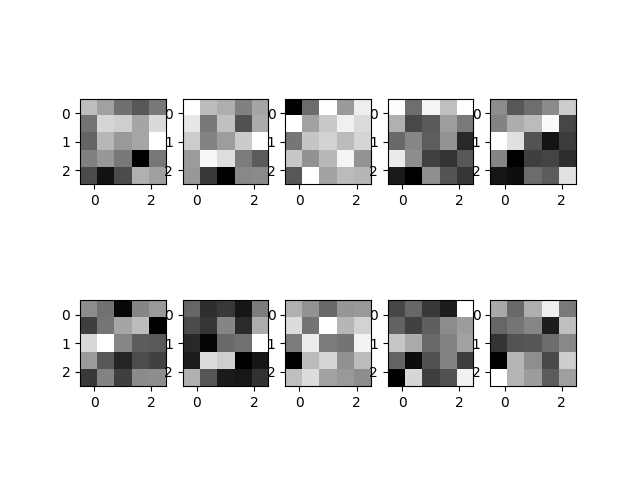

<IPython.core.display.Javascript object>


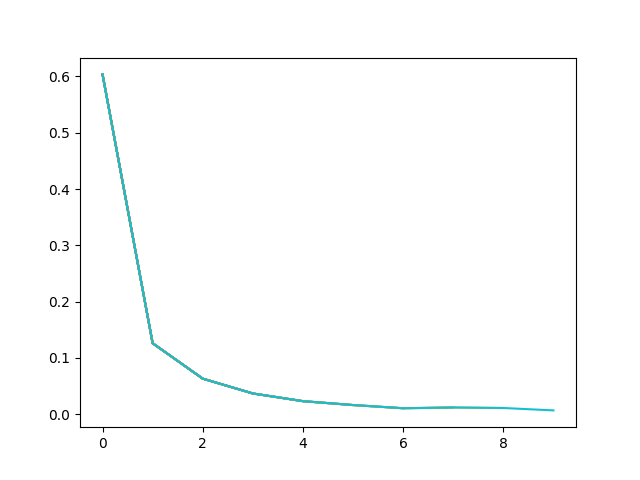

    Loss in epoch 1 for batch 100: 1.3399603903293609
    Loss in epoch 1 for batch 200: 1.0929193672537805
    Loss in epoch 1 for batch 300: 0.9131178526083629
    Loss in epoch 1 for batch 400: 0.7811107911169529
    Loss in epoch 1 for batch 500: 0.6824082433581352
total loss of epoch 1 : 0.6037243224307894
    Loss in epoch 2 for batch 100: 0.1841885806620121
    Loss in epoch 2 for batch 200: 0.16613691538572312
    Loss in epoch 2 for batch 300: 0.15306569362680117
    Loss in epoch 2 for batch 400: 0.1430958320759237
    Loss in epoch 2 for batch 500: 0.13476931451261043
total loss of epoch 2 : 0.12613736319045227
    Loss in epoch 3 for batch 100: 0.08249721802771091
    Loss in epoch 3 for batch 200: 0.07468465717509389
    Loss in epoch 3 for batch 300: 0.07111543311427036
    Loss in epoch 3 for batch 400: 0.06901125212199986
    Loss in epoch 3 for batch 500: 0.0666455186791718
total loss of epoch 3 : 0.06320296072711547
    Loss in epoch 4 for batch 100: 0.047016524150967

In [4]:
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.001)
num_epochs = 10

# this part is for graphic output (still a bit hacky)
fig = plt.figure()
axes = [plt.subplot(2, 5, i) for i in range(1, 11)]
example_img = torch.zeros((3, 3))
example_img[0][0] = 1.0
images = [ax.imshow(example_img, cmap='gray') for ax in axes]

# set graphic objects in debug layer
debug_layer = model[4]
debug_layer.set_figure(fig)
debug_layer.set_images(images)

# we also want the loss to be plotted in a graph
fig2, ax2 = plt.subplots()
loss_plot = None
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0

    model.train()
    for idx, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()

        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if idx % 100 == 0 and idx > 0:
            print(f"    Loss in epoch {epoch + 1} for batch {idx}: {epoch_loss / idx}")
    epoch_loss /= len(train_loader)
    
    losses.append(epoch_loss)
    loss_plot = ax2.plot(losses)
    fig2.canvas.draw()
    print("total loss of epoch", epoch+1, ":", epoch_loss)

You can see as the loss declines the full precision feature maps vary a bit in shade.

Below we evaluate how well our full precision network performs on a test dataset by calculating its accuarcy when confronted with previously unseen examples:

In [5]:
model.eval()
test_loss = 0.0
correct = 0.0
# now validate model with test dataset
with torch.no_grad():
    for x_test, y_test in test_loader:

        y_hat = model(x_test)
        test_loss += criterion(y_hat, y_test).item()

        # determine count of correctly predicted labels
        predictions = torch.argmax(y_hat, dim=1)
        correct += torch.sum(y_test == predictions).item()
test_loss /= len(test_loader)
accuracy = correct / (len(test_loader) * test_loader.batch_size)
print("test loss:", test_loss, "test accuracy:", accuracy)

test loss: 0.038207449839101175 test accuracy: 0.9879


With the full precision version we achieve an accuracy of ~98%-99%.

Next, we want to evaluate the performance of our binary layers by first building a model:

In [7]:
num_convolution_features = 64
num_linear_nodes = 1000
num_output_nodes = 10

model = nn.Sequential(
    # first convolution block
    nn.Conv2d(1, num_convolution_features, kernel_size=5),
    nn.BatchNorm2d(num_convolution_features),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),

    # second convolution blocks
    # previously: Conv2d(num_convolution_features, num_convolution_features, kernel_size=5),
    QActivation(),
    Weight_Graphical_Debug_Layer(
        QConv2d_NoAct(num_convolution_features, num_convolution_features, kernel_size=5),
        num_outputs=10),
    nn.BatchNorm2d(num_convolution_features),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    QActivation(),
    QLinear(num_convolution_features * 4 * 4, num_linear_nodes),
    nn.BatchNorm1d(num_linear_nodes),
    nn.Tanh(),

    nn.Linear(num_linear_nodes, 10),
)

In the quantized LeNet version above we simply exchanged the convolution, linear and activation layers starting from the second convolution block with our corresponding quantized versions.

Note that we also added an additional activation layer in front of the convolution and linear layers. This is necessary because we want to pass already binarized input values to our quantized layers. We want the network to learn on binarized data, so it would not make much sense to pass full precision input values to a layer with binarized weights.

The default QConv2d layer from bittorch already includes this activation layer but for better understanding we used the dedicated QConv2d_NoAct version here.

Now we train this model using the exact same code as before:

<IPython.core.display.Javascript object>


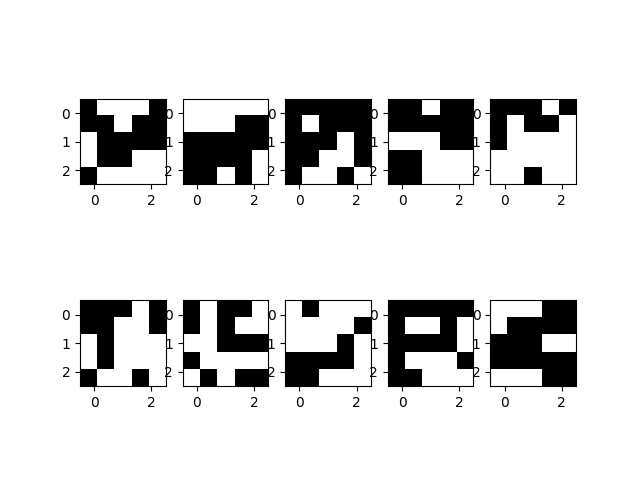

<IPython.core.display.Javascript object>


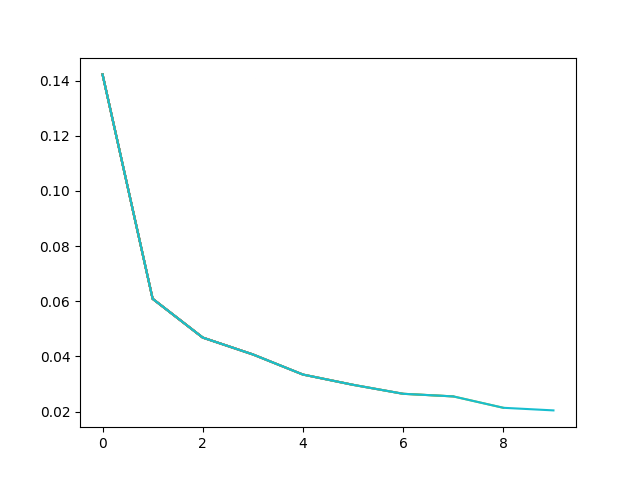

    Loss in epoch 1 for batch 100: 0.322491349875927
    Loss in epoch 1 for batch 200: 0.22968971105758101
    Loss in epoch 1 for batch 300: 0.19139777683032055
    Loss in epoch 1 for batch 400: 0.1685618455382064
    Loss in epoch 1 for batch 500: 0.15476143940910697
total loss of epoch 1 : 0.1422441518958658
    Loss in epoch 2 for batch 100: 0.07754592816345393
    Loss in epoch 2 for batch 200: 0.06867325489874929
    Loss in epoch 2 for batch 300: 0.06562233291333541
    Loss in epoch 2 for batch 400: 0.0653179157548584
    Loss in epoch 2 for batch 500: 0.06264257925003767
total loss of epoch 2 : 0.06090767526135702
    Loss in epoch 3 for batch 100: 0.055412213301751764
    Loss in epoch 3 for batch 200: 0.05020062564057298
    Loss in epoch 3 for batch 300: 0.05038305282825604
    Loss in epoch 3 for batch 400: 0.04992167607182637
    Loss in epoch 3 for batch 500: 0.04857360159466043
total loss of epoch 3 : 0.04684543395516812
    Loss in epoch 4 for batch 100: 0.0488241923

In [8]:
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.001)
num_epochs = 10

# this part is for graphic output (still a bit hacky)
fig = plt.figure()
axes = [plt.subplot(2, 5, i) for i in range(1, 11)]
example_img = torch.zeros((3, 3))
example_img[0][0] = 1.0
images = [ax.imshow(example_img, cmap='gray') for ax in axes]

# set graphic objects in debug layer
debug_layer = model[5]
debug_layer.set_figure(fig)
debug_layer.set_images(images)

# we also want the loss to be plotted in a graph
fig2, ax2 = plt.subplots()
loss_plot = None
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0

    model.train()
    for idx, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()

        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if idx % 100 == 0 and idx > 0:
            print(f"    Loss in epoch {epoch + 1} for batch {idx}: {epoch_loss / idx}")
    epoch_loss /= len(train_loader)
    
    losses.append(epoch_loss)
    loss_plot = ax2.plot(losses)
    fig2.canvas.draw()
    print("total loss of epoch", epoch+1, ":", epoch_loss)

And now we also evaluate the performance of our quantized model:

In [9]:
model.eval()
test_loss = 0.0
correct = 0.0
# now validate model with test dataset
with torch.no_grad():
    for x_test, y_test in test_loader:

        y_hat = model(x_test)
        test_loss += criterion(y_hat, y_test).item()

        # determine count of correctly predicted labels
        predictions = torch.argmax(y_hat, dim=1)
        correct += torch.sum(y_test == predictions).item()
test_loss /= len(test_loader)
accuracy = correct / (len(test_loader) * test_loader.batch_size)
print("test loss:", test_loss, "test accuracy:", accuracy)

test loss: 0.05486298953724145 test accuracy: 0.9855


As we can see the binarized version of LeNet performs slightly worse than the full precision version. But considering that we reduced the number of possible weight and input values from full precision (i.e. 2^32 possible values) to binary (2 possible values) the loss of accuracy is astonishingly small.

With some further tweaks to the binarized LeNet version we are able to reduce this accuracy gap to less than 1-2% while still only working on a 2-bit network.

Our bittorch framework does not yet contain the implementations of speed up operations to fully utilize the binarized feature maps but it already demonstrates the potential performance gains of binary neural networks while still competing with state-of-the-art full precision networks.